In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta
import numpy as np
import networkx as nx
from pyproj import CRS
import osmnx as ox
import pickle
import os
import matplotlib.pyplot as plt
import csv
from random import uniform


%matplotlib inline

In [ ]:
#https://github.com/vta/GTFS-Pandas-Analysis/blob/master/gtfs_simple_analyzer.ipynb
trips = pd.read_csv('../../GTFS/TBS/trips.txt', dtype = str)
routes = pd.read_csv('../../GTFS/TBS/routes.txt', dtype = str)
st = pd.read_csv("../../GTFS/TBS/stop_times.txt", dtype = str)
stops = pd.read_csv("../../GTFS/TBS/stops.txt", dtype = str)
calendar_dates = pd.read_csv("../../GTFS/TBS/calendar_dates.txt", dtype = str)
calnedar = pd.read_csv("../../GTFS/TBS/calendar.txt", dtype = str)

# Graph Time Expand

We want one graph for each day
We want one graph for each service. 

## Nodes
Correspond to events

### Arrival
ID_node, station_id, train_id, arrival_time 
### Departure
ID_node, station_id, train_id, departure_time

## Edges
### Conncection
ID_conncection, u_departure(station i), v_arrival(station i+1), weight = travel_time
### Weitning Time
ID_connection, u_arrival(station i), v_departure(station i), weight = weiting Time

# TOY EXAMPLE

In [80]:
G = nx.MultiGraph(crs = 'EPSG:32631')  # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_weighted_edges_from([(0, 1, 3.0), (1, 2, 7.5), (0,2,9.0)])

In [81]:
G.nodes[0]['pos'] = [0.0,0.0]
G.nodes[0]['x'] = 0.0
G.nodes[0]['y'] = 0.0
G.nodes[0]['geometry'] = Point(G.nodes[0]['pos'])
G.nodes[1]['pos'] = [0.0,2.0]
G.nodes[1]['x'] = 0.0
G.nodes[1]['y'] = 2.0
G.nodes[1]['geometry'] = Point(G.nodes[1]['pos'])
G.nodes[2]['pos'] = [3.0,2.0]
G.nodes[2]['x'] = 3.0
G.nodes[2]['y'] = 2.0
G.nodes[2]['geometry'] = Point(G.nodes[2]['pos'])

In [ ]:
for node_id in G.nodes:
    G.nodes[node_id]['pos'] = [0.0,0.0]
    print(G.nodes[node_id])
    

In [ ]:
G.nodes[2]

In [ ]:
ox.project_graph(G, to_crs = 'EPSG:32631')

In [ ]:
nx.draw(G)

In [ ]:
ox.graph_to_gdfs(G)

In [ ]:
ox.plot_graph(G)

# #2

In [ ]:
# Load List of graphs
with open("../../GTFS/Graphs/Prova/20210326.p", 'rb') as f:
    G = pickle.load(f)

In [ ]:
nx.draw(G)

In [ ]:
G.nodes['E2^4']

In [ ]:
G.edges[('E3^1', 'E2^1', 0)]

In [ ]:
ox.plot_graph(G)

### Routing

In [ ]:
Eudald = (41.387614,2.191922)
Carles = (41.390167,2.188483)
Marisa = (41.394061,2.186917)
Júlia = (41.404450,2.191500)
Maiol = (41.406144,2.198247)
Sabater = (41.407614,2.211922)
Oliveras = (41.367614,2.191922)

In [ ]:
o_point = Eudald
d_point = Oliveras
o = ox.get_nearest_node(G, o_point)
d = ox.get_nearest_node(G, d_point)
o,d

In [ ]:
path = ox.shortest_path(G, o, d, weight='time')
path = nx.dijkstra_path(G,o,d, weight='time')
path

In [ ]:
total_time = 0
for i in range(len(path)-1):
    time = G.edges[path[i],path[i+1],0]['time']
    total_time = total_time + G.edges[path[i],path[i+1],0]['time']
    print(time/60)
print(total_time/60)
total_time/60

# Random graph

In [ ]:
#Get graph BCN from Bbox
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)
east = nodes['x'].max()
west = nodes['x'].min()
north = nodes['y'].max()
south = nodes['y'].min()
G_bbox = ox.graph_from_bbox(north, south, east, west, network_type='walk')
ox.plot_graph(G_bbox)

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,8))
ox.plot_graph(G_bbox, ax = ax1, figsize = fig, node_size = 0,show=False, close=False)
ox.plot_graph(G,ax = ax1, figsize = fig, node_color = 'r', edge_color = 'b')

# Time Dependent

### Get calendar for service id and valid day

In [84]:
direction = '../../GTFS/TBS'
date = '20210326' #'20150611'
day = 'friday'
with open(direction+'/calendar.txt', 'r') as fn:
    reader = csv.reader(fn, delimiter=',')
    fields = next(reader)
    serviceday = dict(zip(fields, range(len(fields))))
    #service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
    validservices = {}
    for row in reader:
        if row[serviceday[day]] == '1':
            validservices[row[serviceday['service_id']]] = 1

with open(direction+'/calendar_dates.txt', 'r') as fn:
    reader = csv.reader(fn, delimiter=',')
    next(reader)
    #service_id,date,exception_type
    serviceexcept = {}
    for row in reader:
        if row[1] == date:
            serviceexcept[row[0]] = row[2] #1 -> add, 2 --> remove

### Filter out the services not applicable to a date

In [85]:
for key in serviceexcept.keys():
    if serviceexcept[key] == '1':   #1 -> add, 2 --> remove
        if key not in validservices:
            validservices[key] = 1  # -> insert an added service if it does not already exist
    elif serviceexcept[key] == '2':
        if key in validservices:
            validservices.pop(key)  # --> pop out an invalid service for the day

validservices

{'DIV_FINS24': 1}

### Get valid trip_id based on valid services

In [86]:
with open(direction+'/trips.txt', 'r') as fn:
    reader = csv.reader(fn, delimiter=',')
    # extracting field names through first row
    fields = next(reader)
    attix = dict(zip(fields, range(len(fields))))
    #print(attix)
    validtrips = {} #gives route id based on trip id
    for row in reader:
        if row[attix['service_id']] in validservices:
            validtrips[row[attix['trip_id']]]=[row[attix['route_id']], row[attix['direction_id']]]
validtrips

{'T4ANA491': ['4', '0'],
 'T4ANA492': ['4', '0'],
 'T4ANA493': ['4', '0'],
 'T4ANA494': ['4', '0'],
 'T4ANA495': ['4', '0'],
 'T4ANA496': ['4', '0'],
 'T4ANA497': ['4', '0'],
 'T4ANA498': ['4', '0'],
 'T4ANA499': ['4', '0'],
 'T4ANA4910': ['4', '0'],
 'T4ANA4911': ['4', '0'],
 'T4ANA4912': ['4', '0'],
 'T4ANA4913': ['4', '0'],
 'T4ANA4914': ['4', '0'],
 'T4ANA4915': ['4', '0'],
 'T4ANA4916': ['4', '0'],
 'T4ANA4917': ['4', '0'],
 'T4ANA4918': ['4', '0'],
 'T4ANA4919': ['4', '0'],
 'T4ANA4920': ['4', '0'],
 'T4ANA4921': ['4', '0'],
 'T4ANA4922': ['4', '0'],
 'T4ANA4923': ['4', '0'],
 'T4ANA4924': ['4', '0'],
 'T4ANA4925': ['4', '0'],
 'T4ANA4926': ['4', '0'],
 'T4ANA4927': ['4', '0'],
 'T4ANA4928': ['4', '0'],
 'T4ANA4929': ['4', '0'],
 'T4ANA4930': ['4', '0'],
 'T4ANA4931': ['4', '0'],
 'T4ANA4932': ['4', '0'],
 'T4ANA4933': ['4', '0'],
 'T4ANA4934': ['4', '0'],
 'T4ANA4935': ['4', '0'],
 'T4ANA4936': ['4', '0'],
 'T4ANA4937': ['4', '0'],
 'T4ANA4938': ['4', '0'],
 'T4ANA4939': ['4', '

### Get stop data

In [87]:
with open(direction+'/stops.txt', 'r', encoding='utf-8-sig') as fn:
    reader = csv.reader(fn, delimiter=',')
    fields = next(reader)
    attix = dict(zip(fields, range(len(fields))))
    stopdata = {}
    for row in reader:
        stopdata[row[attix['stop_id']]] = [row[attix['stop_name']], float(row[attix['stop_lat']]), float(row[attix['stop_lon']])]


### Build edges from the journays of valid trips

In [88]:
def timeFunction(current_time, interpolation_points):
    # Current time is an int representing the seconds from 00:00:00
    # array with touple (departure_time, travel_time)
    next_departure = None
    for point in interpolation_points:
        if current_time <= point[0]:
            next_departure = (point)
        else:
            break
    y = (next_departure[0]-current_time) + next_departure[1]
    
    return y
    

In [89]:
with open(direction+'/stop_times.txt', 'r') as fn:
    reader = csv.reader(fn, delimiter=',')
    # extracting field names through first row
    fields = next(reader)
    attix = dict(zip(fields, range(len(fields))))
    stoptrips = {}
    getstopid = {}
    stop_times = []
    cnt=0
    for row in reader:
        #this builds stop to stop times for valid trips...
        if row[attix['trip_id']] in validtrips:
            stop_times.append(row)
            getstopid[row[attix['trip_id']]+'^'+row[attix['stop_id']]]=[row[attix['stop_id']], row[attix['arrival_time']], row[attix['departure_time']]]
        #this builds wihin stop transfers...
        #MANY BUSSES HAVE NOT TIMES. I SHOULD INTERPOLATE TO GET THE TIMES AND PLACE THEM BACK INTO THE FEED
            try:
                if row[attix['stop_id']] in stoptrips:
                    arr = list(map(int, row[attix['arrival_time']].split(':')))
                    arrtm = arr[0]*3600 + arr[1]*60 + arr[2]
                    dep = list(map(int, row[attix['departure_time']].split(':')))
                    deptm = dep[0]*3600 + dep[1]*60 + dep[2]
                    stoptrips[row[attix['stop_id']]].append([row[attix['trip_id']], arrtm, deptm])
                else:
                    arr = list(map(int, row[attix['arrival_time']].split(':')))
                    arrtm = arr[0]*3600 + arr[1]*60 + arr[2]
                    dep = list(map(int, row[attix['departure_time']].split(':')))
                    deptm = dep[0]*3600 + dep[1]*60 + dep[2]
                    stoptrips[row[attix['stop_id']]]=[[row[attix['trip_id']], arrtm, deptm]]
            except:
                if cnt < 10:
                    print('Failed to convert data for row: ', row)
                    cnt +=1
                else:
                    pass

In [90]:
def filter_timetable_by_route(stop_id, route, stoptrips, validtrips):
    filtered_times = []
    all_times = stoptrips[str(stop_id)]
    for event in all_times:
        if validtrips[event[0]] == route:  # Checks the route and the direction 
            filtered_times.append(event)
    return filtered_times

In [91]:
route_built = []
edges = []
transfer_time = 120
for trip in validtrips.items():
    # Check which routes have we already built
    route = trip[1]
    if route in route_built:
        continue
    else:
        # Build the linial graph: Each one of the routes
        route_stops = {} 
        for stop_service in stop_times: #Stop Times are the all stops times for all valid trips
            if stop_service[0] == trip[0]: # Check if the trips belongs to the route.
                route_stops[stop_service[3]] = stop_service[4]     #dict (stop_id: stop_sec)
        #route_stops = dict(sorted(route_stops.items(), key=lambda item: item[1]))   
        print(route_stops)
        
        #Build the interpolation points and the transfers edges.
        stop_ids = list(route_stops.keys())
        for stop_index in range(0, len(stop_ids)):
            stop_id_departure = stop_ids[stop_index]
            if stop_id_departure == stop_ids[-1]:
                edges.append([str(route[0])+'_'+str(route[1])+'^'+stop_id_departure,
                              'Super'+'^'+stop_id_departure,
                              transfer_time])
                edges.append(['Super'+'^'+stop_id_departure,
                              str(route[0])+'_'+str(route[1])+'^'+stop_id_departure,
                              transfer_time])
                break
            else:
                stop_id_arrival = stop_ids[stop_index+1]
                #Linear
                #Get the interpolation points 
                dept_events = filter_timetable_by_route(stop_id_departure, route, stoptrips,validtrips)
                arri_events = filter_timetable_by_route(stop_id_arrival, route, stoptrips,validtrips)
                interpolation_points = []
                for dept, arri in zip(dept_events, arri_events):
                    interpolation_points.append([dept[2], arri[1] - dept[2]])   #Departure time, travel time             
                
                #Append edge
                edges.append([str(route[0])+'_'+str(route[1])+'^'+stop_id_departure,
                              str(route[0])+'_'+str(route[1])+'^'+stop_id_arrival,
                              interpolation_points])
                #Transfer
                edges.append([str(route[0])+'_'+str(route[1])+'^'+stop_id_departure,
                              'Super'+'^'+stop_id_departure, 
                              transfer_time])
                edges.append(['Super'+'^'+stop_id_departure,
                              str(route[0])+'_'+str(route[1])+'^'+stop_id_departure,
                              transfer_time])

        route_built.append(route)

print(len(edges))


{'20': '1', '21': '2', '22': '3', '2': '4', '3': '5', '4': '6', '5': '7', '6': '8', '7': '9', '8': '10', '9': '11', '10': '12', '29': '13', '30': '14'}
{'30': '1', '29': '2', '10': '3', '9': '4', '8': '5', '7': '6', '6': '7', '5': '8', '4': '9', '3': '10', '2': '11', '22': '12', '21': '13', '20': '14'}
{'3': '1', '3bis': '2', '23': '3', '24': '4', '25': '5', '26': '6', '27': '7', '28': '8', '13': '9', '14': '10', '16': '11', '17': '12', '19': '13'}
{'19': '1', '17': '2', '16': '3', '14': '4', '13': '5', '28': '6', '27': '7', '26': '8', '25': '9', '24': '10', '23': '11', '3bis': '12', '3': '13'}
{'3': '1', '3bis': '2', '23': '3', '24': '4', '25': '5', '26': '6', '27': '7', '28': '8', '11': '9', '29': '10', '30': '11'}
{'30': '1', '29': '2', '11': '3', '28': '4', '27': '5', '26': '6', '25': '7', '24': '8', '23': '9', '3bis': '10', '3': '11'}
222


In [92]:
# Set interpolation Points

### Build Graph

In [93]:
G = nx.MultiDiGraph(crs = 'EPSG:32631')
G.add_weighted_edges_from(edges, 'time')

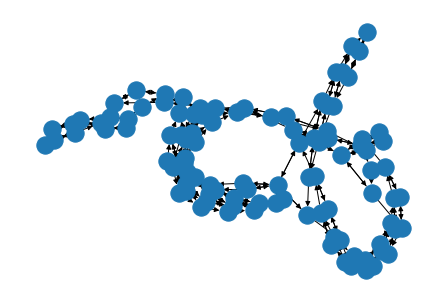

In [94]:
nx.draw(G)

In [95]:
for node_id in G.nodes:
    try:
        route, station = node_id.split('^')
        stop_lat = stopdata[station][1]
        stop_lon = stopdata[station][2]
        G.nodes[node_id]['x'] = stop_lon + uniform(0,0.001)
        G.nodes[node_id]['y'] = stop_lat + uniform(0,0.003)
        if route == 'Super':
            G.nodes[node_id]['x'] = stop_lon + 0.002
            G.nodes[node_id]['y'] = stop_lat + 0.000
    except:
        print('Failed to find the station id: ', station)

In [96]:
?ox.plot_graph

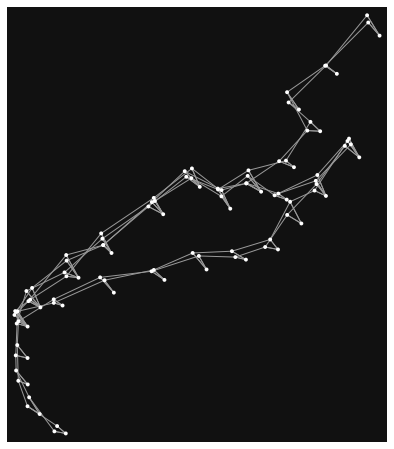

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [97]:
ox.plot_graph(G)

In [ ]:
import random
import time
from queue import PriorityQueue

import matplotlib
import numpy as np

matplotlib.use("tkagg")
import pandas as pd


class Graph(object):
    def __init__(self, vertices, edges, weights):
        self.vertices = vertices
        self.edges = edges
        self.weights = weights
        self.in_adj = list()
        self.out_adj = list()

        for v in vertices:
            self.in_adj.append(list())
            self.out_adj.append(list())

        for e in edges:
            self.in_adj[e[1]].append(e)
            self.out_adj[e[0]].append(e)


class Pair(object):
    def __init__(self, tau, g, v):
        self.tau = tau
        self.g = g
        self.v = v

    def __cmp__(self, other):
        return cmp(self.g[self.tau[self.v]], other.g[other.tau[other.v]])

    def __str__(self):
        return str((self.v, self.tau[self.v], self.g[self.tau[self.v]]))

    def __repr__(self):
        return str((self.v, self.tau[self.v], self.g[self.tau[self.v]]))


def time_refinement(Gt, vs, ve, T):
    ts = T[0]
    te = T[-1]
    g = dict()
    g[vs] = dict()
    for t in T:
        g[vs][t] = t
    tau = dict()
    tau[vs] = ts

    for v in Gt.vertices:
        if v != vs:
            g[v] = dict()
            for t in T:
                g[v][t] = np.inf
            tau[v] = ts

    Q_ = [Pair(tau, g[i], i) for i in Gt.vertices]
    Q = PriorityQueue()
    for p in Q_:
        Q.put(p)

    while len(Q.queue) >= 2:
        pair_i = Q.get()
        pair_k = Q.get()
        Q.put(pair_k)
        tmp = [Gt.weights[e](g[pair_k.v][tau[pair_k.v]]) for e in Gt.in_adj[pair_i.v]]
        delta = np.min(tmp) if len(tmp) > 0 else np.inf
        tau_i_first = np.max([t for t in T if g[pair_i.v][t] <= (g[pair_k.v][tau[pair_k.v]] + delta)])

        for e in Gt.out_adj[pair_i.v]:
            gj_first = dict()
            for t in range(pair_i.tau[pair_i.v], tau_i_first + 1):
                gj_first[t] = pair_i.g[t] + Gt.weights[e](pair_i.g[t])
                g[e[1]][t] = min(g[e[1]][t], gj_first[t])

            tmpQ = PriorityQueue()
            for p in Q.queue:
                tmpQ.put(p)
            Q = tmpQ

        tau[pair_i.v] = tau_i_first

        if tau[pair_i.v] >= te:
            if pair_i.v == ve:
                return g
        else:
            Q.put(Pair(tau, pair_i.g, pair_i.v))
    return g


def path_selector(Gt, g, vs, ve, t_star):
    vj = ve
    p_star = list()
    while vj != vs:
        for e in Gt.in_adj[vj]:
            if g[e[0]][t_star] + Gt.weights[e](g[e[0]][t_star]) == g[vj][t_star]:
                vj = e[0]
                break
        p_star.append([e[0], e[1], g[e[1]][t_star]])
    return list(reversed(p_star))


def algorithm(Gt, vs, ve, T):
    g = time_refinement(Gt, vs, ve, T)

    if sum(np.isinf(g[ve].values())) == 0:
        t_star = np.argmin([g[ve][t] - t for t in T])
        p_star = path_selector(Gt, g, vs, ve, t_star)
        return t_star, p_star
    else:
        return None


if __name__ == "__main__":
    # Given v_s and v_e and a time window T, find the best time within T to depart from v_s and the path along which one
    # can arrive at v_e with the minimum travel time

    # algorithm

    # Input:
    # Gt = time dependent graph
    # vs = starting vertex
    # ve = destination vertex
    # T  = start time interval

    # Output:
    # t_ = optimal starting time
    # p_ = optimal vs-ve path. [vi, vj, time to reach vj]

    # Weights:
    # the weight of an edge v(i,j) depends on time t and it is defined by the function wi_j

    def w0_2(t):
        if 0 <= t < 5:
            return 5
        if t >= 10:
            return 25
        if 5 <= t < 10:
            return 4 * t - 15


    def w0_1(t):
        return 10


    def w1_2(t):
        return 10


    def w1_3(t):
        return 25


    def w2_3(t):
        return 10 if t >= 40 else 42 - 4.0 / 5.0 * t


    start_time = time.time()

    T = range(0, 61)
    vertices = {0: 0, 1: 1, 2: 2, 3: 3}
    vs = 0
    ve = 3
    edges = [(0, 2), (1, 2), (0, 1), (1, 3), (2, 3)]
    weights = {(0, 2): w0_2, (1, 2): w1_2, (0, 1): w0_1, (1, 3): w1_3, (2, 3): w2_3}
    Gt = Graph(vertices, edges, weights)
    print(algorithm(Gt, vs, ve, T))

    print(time.time() - start_time)

    res = []
    for ii in range(1, 100):
        T2 = range(0, ii)
        vertices2 = dict()
        for i in range(ii): vertices2[i] = i
        l = len(vertices2)
        edges2 = [(i, j) for i in range(l) for j in range(l) if random.random() < 0.5]
        weights2 = dict()
        all_w = [w0_2, w1_2, w0_1, w1_3, w2_3]
        for e in edges2:
            weights2[e] = all_w[random.randint(0, 4)]
        Gt = Graph(vertices2, edges2, weights2)

        start_time = time.time()
        p = algorithm(Gt, random.randint(0, ii - 1), random.randint(0, ii - 1), T2)
        end = time.time() - start_time
        item = [ii, end, len(vertices2), len(edges2), len(T2)]
        print((p, item)) 
        res.append(item)

    df = pd.DataFrame(res, columns=["i", "time_elapsed", "n", "m", "T"])
    df["time_elapsed"].plot()